### TODO
-  スペクトルクラスタリングによる可視化
    - 元データの学習されたパラメータ
- ノード特徴量の二次元への可視化
    - 同一コミュニティに属するノード特徴量は直線上に存在する

**実験について**
- 重みなし無向グラフとして扱う
- 初期条件を複数用意し，最大尤度のモデルを使用
- 可視化について
    - 元データ
    - DCSBMの学習表現
    - 推定データと元データのエッジの有無を一致させたもの

**次元削減**
- UMAP, T-SNEで可視化
- UMAPのパラメータ
    - n_neighborn : 平均次数
    - metric : ユークリッド距離，コサイン類似度の両方

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import networkx as nx
from collections import defaultdict
from src.DCSBM import DCSBM_NW
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
import matplotlib.pyplot as plt
from src.myfunction import make_polblogs_graph
import numpy as np
from sklearn.cluster import SpectralClustering
from src.myfunction import eigen
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score

In [2]:
# カスタムカラーマップの作成
def create_custom_cmap(n_colors):
    if n_colors == 2:
        colors = ['#1f77b4', '#ff7f0e']
    elif n_colors == 3:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    else:
        raise ValueError("This function only supports 2 or 3 colors.")
    
    return LinearSegmentedColormap.from_list("custom", colors, N=n_colors)

cmap_2color = create_custom_cmap(2)
cmap_3color = create_custom_cmap(3)

## 空手クラブ　

In [3]:
# 空手クラブのネットワークを読み込む
G = nx.karate_club_graph()
club_labels = nx.get_node_attributes(G, 'club')
true_communities = [1 if club_labels[node] == 'Mr. Hi' else 0 for node in G.nodes()]

# 確率ブロックモデルの学習
max_ll = -1e9
max_seed = -1

for seed in range(0,20):
    dcsbm = DCSBM_NW.DCSBM(G, 2, seed)
    dcsbm.fit() 
    ll: float = dcsbm.log_likelihood()
    if ll > max_ll:
        max_ll = ll
        max_seed = seed

print(max_ll)
print(max_seed)

  2%|▏         | 2/100 [00:00<00:00, 1264.11it/s]

-739.3884041633212
19


In [4]:
# 最も尤度関数の値の大きい学習結果を採用
best_dcsbm = DCSBM_NW.DCSBM(G, 2, max_seed)
best_dcsbm.fit()
w = best_dcsbm.get_w()
theta = best_dcsbm.get_theta()
communities = best_dcsbm.get_communities()
A = best_dcsbm.calculate_adjancency_matrix_sub()
avdg = int(best_dcsbm.get_mean_degree())

N = G.number_of_nodes()
A_expected = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        A_expected[i][j] = theta[i]*theta[j]*w[communities[i]][communities[j]]

A_expected_zero = A_expected*A

print(f"平均次数：{avdg}")

  2%|▏         | 2/100 [00:00<00:00, 389.10it/s]

平均次数：4


### 空手クラブ ~ラベルの再現~ 

In [5]:
# UMAPを適用し、2次元に埋め込む
embedding_orig = umap.UMAP(n_components=2, n_neighbors=15, random_state=22, metric="cosine").fit_transform(A)
embedding_expected = umap.UMAP(n_components=2, n_neighbors=15, random_state=22, metric="cosine").fit_transform(A_expected)

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
# DBSCANクラスタリングの実行
dbscan = DBSCAN(eps=0.5, min_samples=5)  # パラメータは調整が必要
clusters1 = dbscan.fit_predict(embedding_orig)

# クラスタリング結果の表示
unique_clusters = np.unique(clusters1)
n_clusters = len(unique_clusters) - (1 if -1 in clusters1 else 0)  # ノイズポイントを除外
print(f"検出されたクラスタ数: {n_clusters}")

検出されたクラスタ数: 2


In [7]:
# DBSCANクラスタリングの実行
dbscan = DBSCAN(eps=1.0, min_samples=5)  # パラメータは調整が必要
clusters2 = dbscan.fit_predict(embedding_expected)

# クラスタリング結果の表示
unique_clusters = np.unique(clusters2)
n_clusters = len(unique_clusters) - (1 if -1 in clusters2 else 0)  # ノイズポイントを除外
print(f"検出されたクラスタ数: {n_clusters}")

検出されたクラスタ数: 2


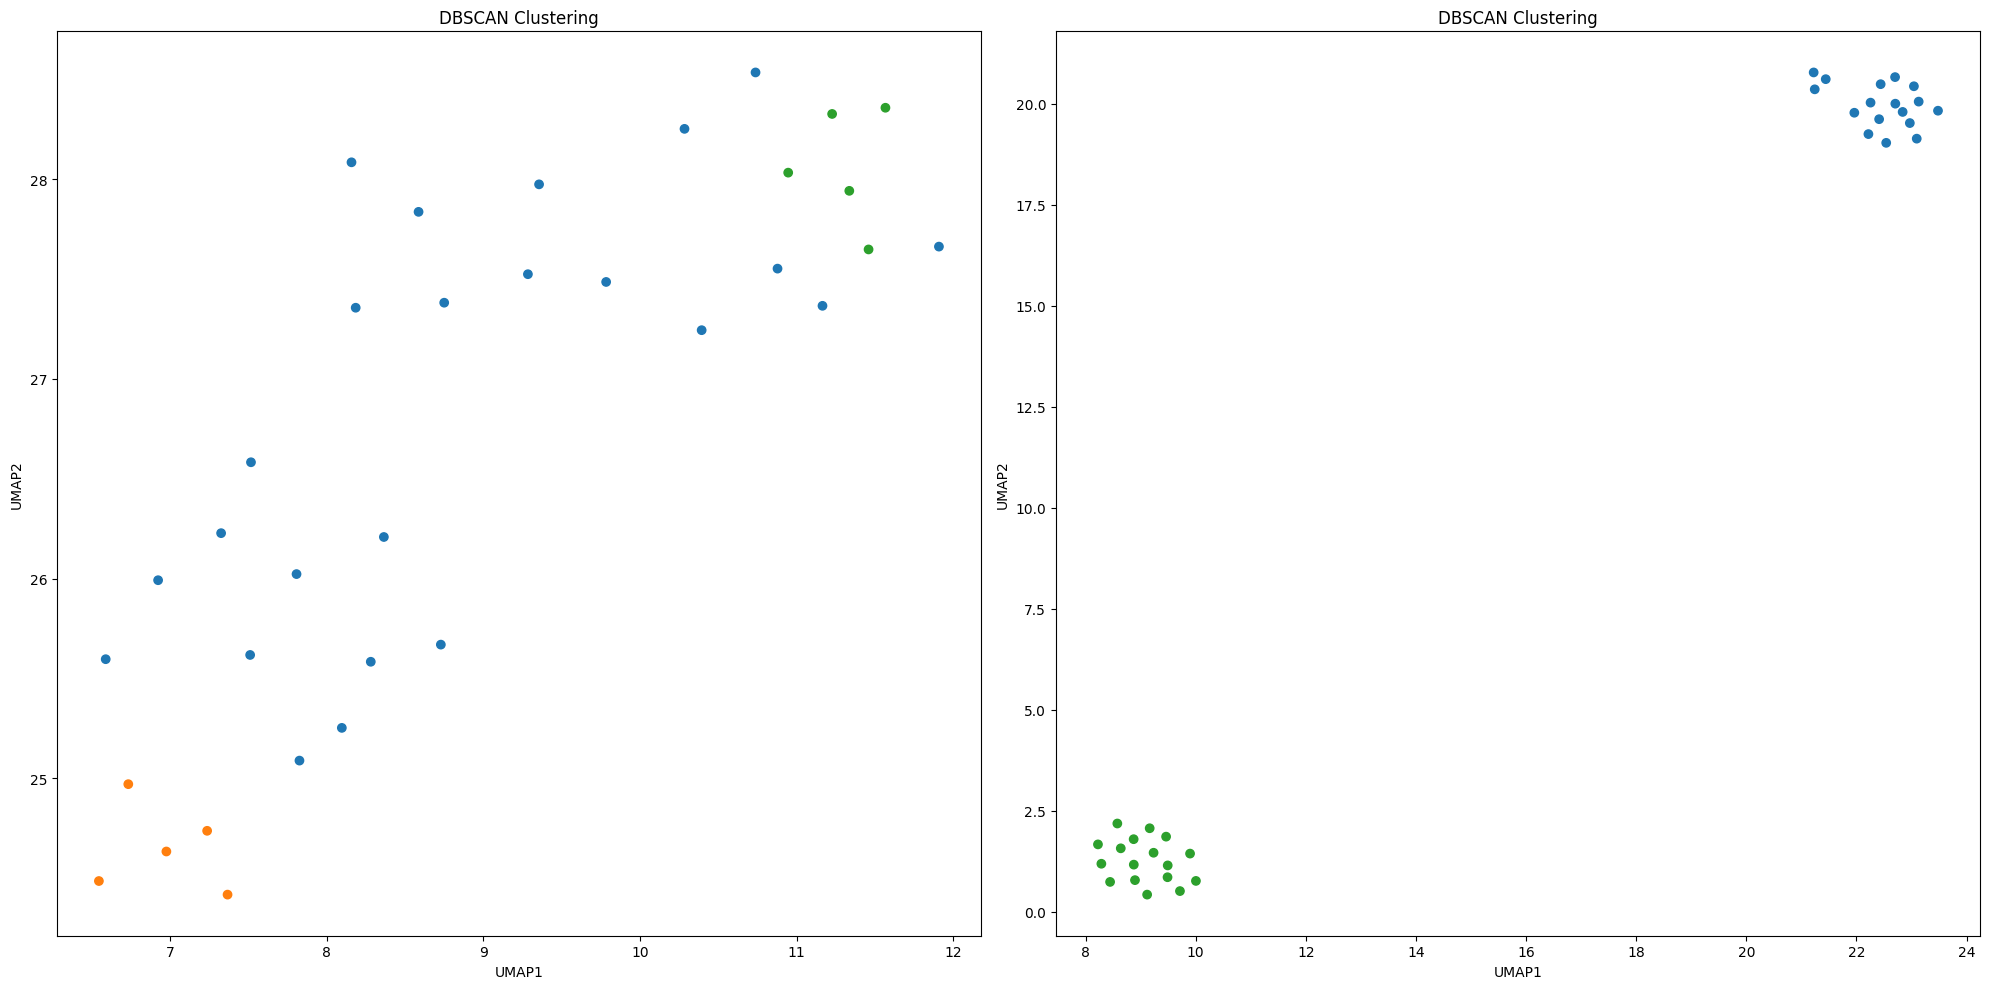

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c=clusters1, cmap=cmap_3color)
ax1.set_title('DBSCAN Clustering')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')

# DBSCANの結果をプロット
ax2.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=clusters2, cmap=cmap_3color)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')

plt.tight_layout()
plt.show()

In [59]:
print(accuracy_score(communities, clusters1))
print(accuracy_score(communities, clusters2))

0.29411764705882354
1.0


In [10]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

def calculate_nmi(true_communities, communities, clusters1, clusters2):
    """
    Calculate Normalized Mutual Information (NMI) for two pairs of community assignments.
    
    :param true_communities: Ground truth community assignments
    :param communities: Predicted community assignments
    :param clusters1: First set of cluster assignments
    :param clusters2: Second set of cluster assignments
    :return: Dictionary containing NMI scores
    """
    nmi_scores = {}
    
    # Calculate NMI between true_communities and clusters1
    nmi_scores['true_communities_vs_clusters1'] = normalized_mutual_info_score(
        true_communities, clusters1
    )
    
    # Calculate NMI between communities and clusters2
    nmi_scores['communities_vs_clusters2'] = normalized_mutual_info_score(
        communities, clusters2
    )
    
    return nmi_scores

# # Example usage
# true_communities = [0, 0, 0, 1, 1, 1, 2, 2, 2]
# communities = [0, 0, 1, 1, 1, 2, 2, 2, 2]
# clusters1 = [0, 0, 0, 1, 1, 1, 2, 2, 2]
# clusters2 = [0, 0, 1, 1, 2, 2, 2, 1, 1]

# nmi_results = calculate_nmi(true_communities, communities, clusters1, clusters2)

# print("NMI Results:")
# for comparison, score in nmi_results.items():
#     print(f"{comparison}: {score:.4f}")

# PolBlogs

### PolBlogs　~スペクトルクラスタリング可視化~

In [3]:
from myfunction import make_polblogs_graph
edge_path = "../data/polblogs/edges.csv"
nodes_path = "../data/polblogs/nodes.csv"
G, true_communities = make_polblogs_graph.make_polblogs_graph(edge_path=edge_path, node_path=nodes_path)

# 部分グラフについて
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(f"部分グラフの数{len(S)}")

# 部分グラフの構成の確認
sub_graph_info = defaultdict(int)
for sub_graph in S:
    sub_graph_info[sub_graph.number_of_nodes()] += 1

print(sub_graph_info)

# 最大連結成分の部分グラフを使用する
Gs = S[0]

header information
['0', '100monkeystyping.com', 'Blogarama', '0', 'array([ 19.03671634, -10.42473   ])']
ノード数:1490
ture_communityの配列のサイズ:1490
defaultdict(<class 'int'>, {1: 14357, 2: 2350, 3: 11})
部分グラフの数268
defaultdict(<class 'int'>, {1222: 1, 1: 266, 2: 1})


In [4]:
# 最も尤度関数の値の大きい学習結果を採用
max_seed = 16
best_dcsbm = DCSBM_NW.DCSBM(Gs, 2, max_seed, sub_graph=True)
best_dcsbm.fit()
w = best_dcsbm.get_w()
theta = best_dcsbm.get_theta()
communities = best_dcsbm.get_communities()
A_non_weight = best_dcsbm.calculate_adjancency_matrix_sub()
avdg = int(best_dcsbm.get_mean_degree())
A = nx.to_numpy_array(Gs)

N = Gs.number_of_nodes()
A_expected = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        A_expected[i][j] = theta[i]*theta[j]*w[communities[i]][communities[j]]

A_expected_zero = A_expected*A_non_weight

print(f"平均次数：{avdg}")

  7%|▋         | 7/100 [00:08<01:57,  1.26s/it]


平均次数：27


###  スペクトルクラスタリング

In [11]:
# 元データに対するスペクトルクラスタリング
spectral_clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)
spectral_clustering.fit(A_non_weight)

# クラスタリング結果の取得
labels = spectral_clustering.labels_

A_x, A_y = eigen.SpectralClusteringPlot(A_non_weight)

(-1.1605629126201875e-13+0j) [0.02860648+0.j 0.02860648+0.j 0.02860648+0.j ... 0.02860648+0.j
 0.02860648+0.j 0.02860648+0.j]
(0.16869150828350712+0j) [0.00158866+0.j 0.0015918 +0.j 0.00172488+0.j ... 0.00188647+0.j
 0.00156824+0.j 0.00191585+0.j]
(0.29954662228214146+0j) [-0.0012854 +0.j -0.00131095+0.j -0.00137781+0.j ... -0.00161035+0.j
 -0.00112798+0.j -0.00153433+0.j]


In [12]:
# 期待値ネットワークに対するスペクトルクラスタリング
spectral_clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)
spectral_clustering.fit(A_expected)

# クラスタリング結果の取得
labels_expected = spectral_clustering.labels_

A_expected_x, A_expected_y = eigen.SpectralClusteringPlot(A_expected)

0j [-0.02860648+0.j -0.02860648+0.j -0.02860648+0.j ... -0.02860648+0.j
 -0.02860648+0.j -0.02860648+0.j]
(0.9703763567858115+0j) [ 0.00258411+0.j  0.00254249+0.j  0.00328445+0.j ... -0.08738894+0.j
 -0.00273629+0.j -0.08738894+0.j]
(0.9999999999999661-3.1452224353856258e-15j) [ 5.75681010e-16+3.13568814e-17j  5.81379809e-16+1.45635242e-16j
  4.18563796e-15+2.58965269e-15j ...  1.82321638e-02-2.87108967e-03j
 -4.03982003e-16-2.33664001e-16j -3.35746667e-03-3.34988600e-03j]


### 固有ベクトルの検証

In [5]:
degree_matrix = np.diag(np.sum(A, axis=1))
laplacian_matrix = degree_matrix - A
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

# 固有値と固有ベクトルのペアを固有値の昇順でソート
eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0])

print(eigen_pairs[0][0],eigen_pairs[0][1])
print(eigen_pairs[1][0],eigen_pairs[1][1])
print(eigen_pairs[2][0], eigen_pairs[2][1])

# return eigen_pairs[1][1], eigen_pairs[2][1]

-1.390188638390838e-13 [-0.02860648 -0.02860648 -0.02860648 ... -0.02860648 -0.02860648
 -0.02860648]
0.17091960034735248 [0.00158661 0.00158902 0.00172111 ... 0.00184461 0.00152933 0.0019205 ]
0.29959592479462827 [-0.00128356 -0.00130477 -0.00137954 ... -0.0016017  -0.00112183
 -0.00155376]


In [17]:
a = [[ 1, -1],[ -1, 1]]

degree_matrix = np.diag(np.sum(a, axis=1))
laplacian_matrix = degree_matrix - a
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

# 固有値と固有ベクトルのペアを固有値の昇順でソート
eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0])

print(eigen_pairs[0][0],eigen_pairs[0][1])
print(eigen_pairs[1][0],eigen_pairs[1][1])

degree_matrix = np.diag(np.sum(a, axis=1))
laplacian_matrix = degree_matrix - a
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

# 固有値と固有ベクトルのペアを固有値の昇順でソート
eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0])

print(eigen_pairs[0][0],eigen_pairs[0][1])
print(eigen_pairs[1][0],eigen_pairs[1][1])

-2.0 [-0.70710678  0.70710678]
0.0 [0.70710678 0.70710678]
-2.0 [ 0.70710678 -0.70710678]
0.0 [0.70710678 0.70710678]


In [18]:
import numpy as np

def is_symmetric(matrix, tol=1e-8):
    """
    行列が実対称行列かどうかをチェックする関数
    
    :param matrix: チェックする行列（NumPy配列）
    :param tol: 許容誤差（デフォルトは1e-8）
    :return: 行列が実対称の場合True、そうでない場合False
    """
    # 行列が正方行列かチェック
    if matrix.shape[0] != matrix.shape[1]:
        return False
    
    # 行列が実数かチェック
    if not np.isreal(matrix).all():
        return False
    
    # 行列が対称かチェック
    return np.allclose(matrix, matrix.T, atol=tol)

# 使用例
A = np.array([[1, 2, 3],
              [2, 4, 5],
              [3, 5, 6]])

print(f"行列 A:\n{A_expected}")
print(f"A は実対称行列か？: {is_symmetric(A_expected)}")

# # 非対称行列の例
# B = np.array([[1, 2, 3],
#               [4, 5, 6],
#               [7, 8, 9]])

# print(f"\n行列 B:\n{B}")
# print(f"B は実対称行列か？: {is_symmetric(B)}")

行列 A:
[[3.96727821e-02 6.86644306e-02 6.10350495e-03 ... 1.13252933e-04
  2.03855279e-03 1.13252933e-04]
 [6.86644306e-02 1.18842284e-01 1.05637586e-02 ... 1.96014691e-04
  3.52826444e-03 1.96014691e-04]
 [6.10350495e-03 1.05637586e-02 9.39000761e-04 ... 1.74235281e-05
  3.13623506e-04 1.74235281e-05]
 ...
 [1.13252933e-04 1.96014691e-04 1.74235281e-05 ... 5.26005847e-05
  9.46810525e-04 5.26005847e-05]
 [2.03855279e-03 3.52826444e-03 3.13623506e-04 ... 9.46810525e-04
  1.70425895e-02 9.46810525e-04]
 [1.13252933e-04 1.96014691e-04 1.74235281e-05 ... 5.26005847e-05
  9.46810525e-04 5.26005847e-05]]
A は実対称行列か？: True


-6.883097369654081 [-0.03398189 -0.04189137 -0.0084637  ... -0.00365579 -0.02881892
 -0.00282832]
-1.8248609018307484 [-0.02531868 -0.03285118 -0.00052005 ...  0.01793576  0.05066602
  0.01031659]
-0.4450197028079934 [1.92029953e-05 1.14819233e-05 6.51506890e-05 ... 4.81306356e-05
 6.95497167e-05 9.50591826e-05]


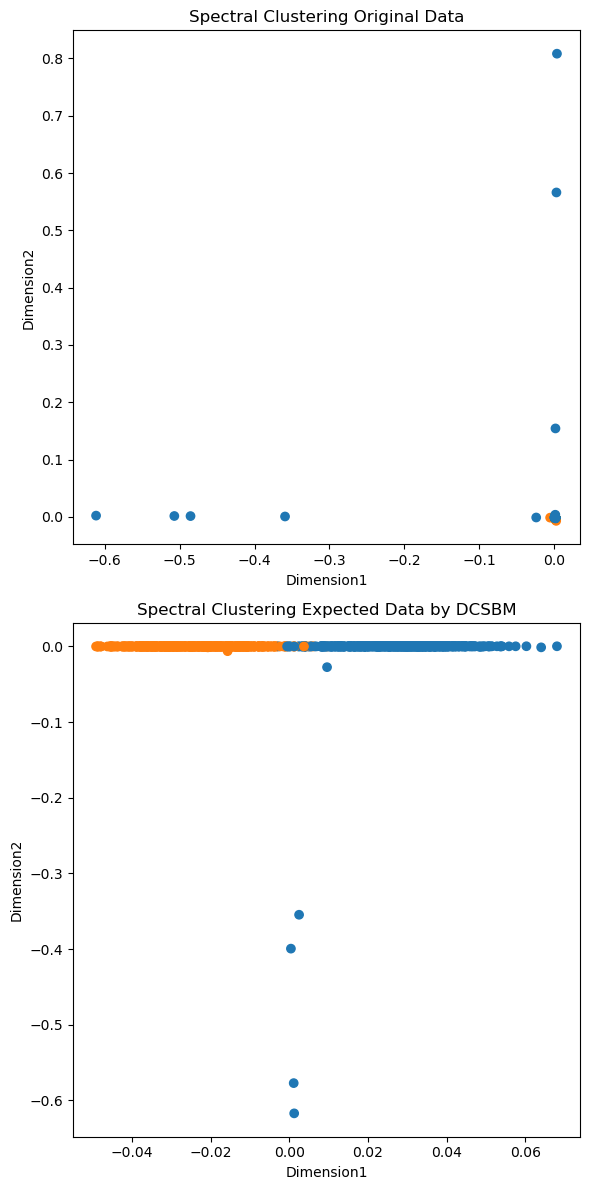

In [12]:
degree_matrix = np.diag(np.sum(A, axis=1))
laplacian_matrix = degree_matrix - A
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

# 固有値と固有ベクトルのペアを固有値の昇順でソート
eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0])

A_xx = eigen_pairs[1][1]
A_yy = eigen_pairs[2][1]

degree_matrix = np.diag(np.sum((A_expected + A_expected.T) / 2 , axis=1))
laplacian_matrix = degree_matrix - A
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

# 固有値と固有ベクトルのペアを固有値の昇順でソート
eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

print(eigen_pairs[0][0],eigen_pairs[0][1])
print(eigen_pairs[1][0],eigen_pairs[1][1])
print(eigen_pairs[2][0], eigen_pairs[2][1])

A_expected_xx = eigen_pairs[1][1]
A_expected_yy = eigen_pairs[2][1]

ax1.scatter(A_xx, A_yy, c=communities, cmap=cmap_2color)
ax1.set_title('Spectral Clustering Original Data')
ax1.set_xlabel('Dimension1')
ax1.set_ylabel('Dimension2')

ax2.scatter(A_expected_xx, A_expected_yy, c=communities, cmap=cmap_2color)
ax2.set_title('Spectral Clustering Expected Data by DCSBM')
ax2.set_xlabel('Dimension1')
ax2.set_ylabel('Dimension2')

plt.tight_layout()
plt.show()

### 固有ベクトルの検証ここまで

In [16]:
def analyze_numbers(A_x, A_y):
    result = {}
    
    for name, lst in [("A_x", A_x), ("A_y", A_y)]:
        positive_count = sum(1 for num in lst if num > 0)
        negative_count = sum(1 for num in lst if num < 0)
        positive_sum = sum(num for num in lst if num > 0)
        negative_sum = sum(num for num in lst if num < 0)
        
        result[name] = {
            "positive_count": positive_count,
            "negative_count": negative_count,
            "positive_sum": positive_sum,
            "negative_sum": negative_sum
        }
    
    return result

analysis_result = analyze_numbers(A_x, A_y)

for lst_name, data in analysis_result.items():
    print(f"リスト {lst_name}:")
    print(f"  正の数の個数: {data['positive_count']}")
    print(f"  負の数の個数: {data['negative_count']}")
    print(f"  正の数の和: {data['positive_sum']}")
    print(f"  負の数の和: {data['negative_sum']}")
    print()

リスト A_x:
  正の数の個数: 1216
  負の数の個数: 6
  正の数の和: (1.9952255615013181+0j)
  負の数の和: (-1.9952255614999412+0j)

リスト A_y:
  正の数の個数: 13
  負の数の個数: 1209
  正の数の和: (1.5444312667710833+0j)
  負の数の和: (-1.5444312667714282+0j)



In [17]:
analysis_result = analyze_numbers(A_expected_x, A_expected_y)

for lst_name, data in analysis_result.items():
    print(f"リスト {lst_name}:")
    print(f"  正の数の個数: {data['positive_count']}")
    print(f"  負の数の個数: {data['negative_count']}")
    print(f"  正の数の和: {data['positive_sum']}")
    print(f"  負の数の和: {data['negative_sum']}")
    print()

リスト A_x:
  正の数の個数: 562
  負の数の個数: 660
  正の数の和: (7.427389844572576+0j)
  負の数の和: (-7.427389844572732+0j)

リスト A_y:
  正の数の個数: 532
  負の数の個数: 690
  正の数の和: (2.969414016811143+0.23750209414341028j)
  負の数の和: (-2.969414016810977-0.23750209414357482j)



In [15]:
res = 0
for value in A_x:
    res += value

print(res)

(1.3781549686175953e-12+0j)


/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


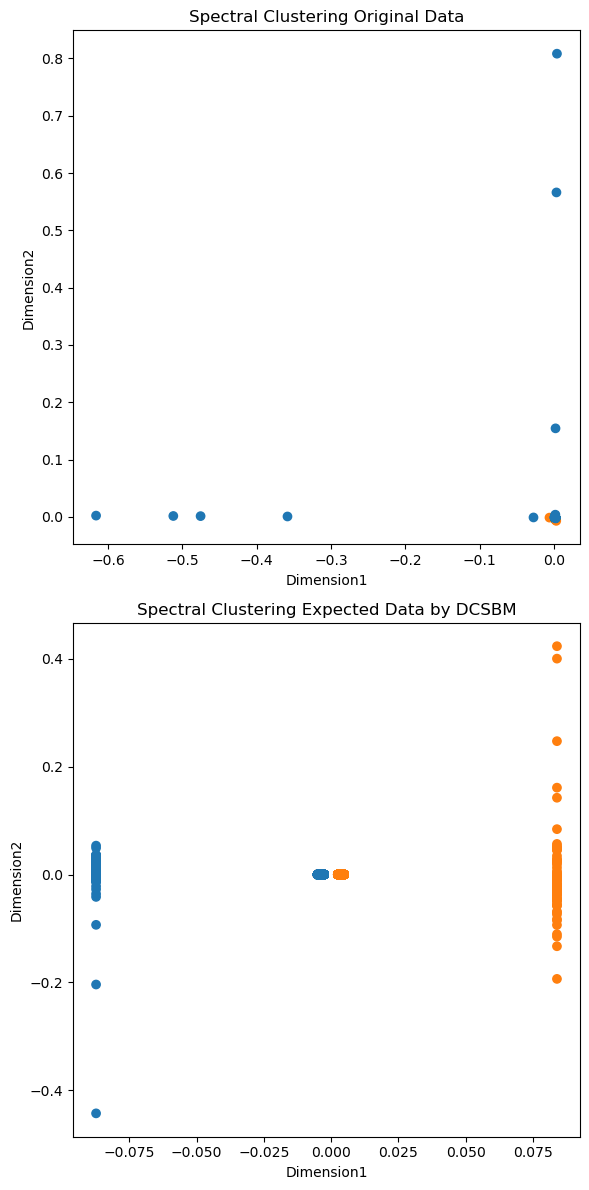

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.scatter(A_x, A_y, c=communities, cmap=cmap_2color)
ax1.set_title('Spectral Clustering Original Data')
ax1.set_xlabel('Dimension1')
ax1.set_ylabel('Dimension2')

ax2.scatter(A_expected_x, A_expected_y, c=communities, cmap=cmap_2color)
ax2.set_title('Spectral Clustering Expected Data by DCSBM')
ax2.set_xlabel('Dimension1')
ax2.set_ylabel('Dimension2')

plt.tight_layout()
plt.show()

### Polblogs ~特徴量の可視化~

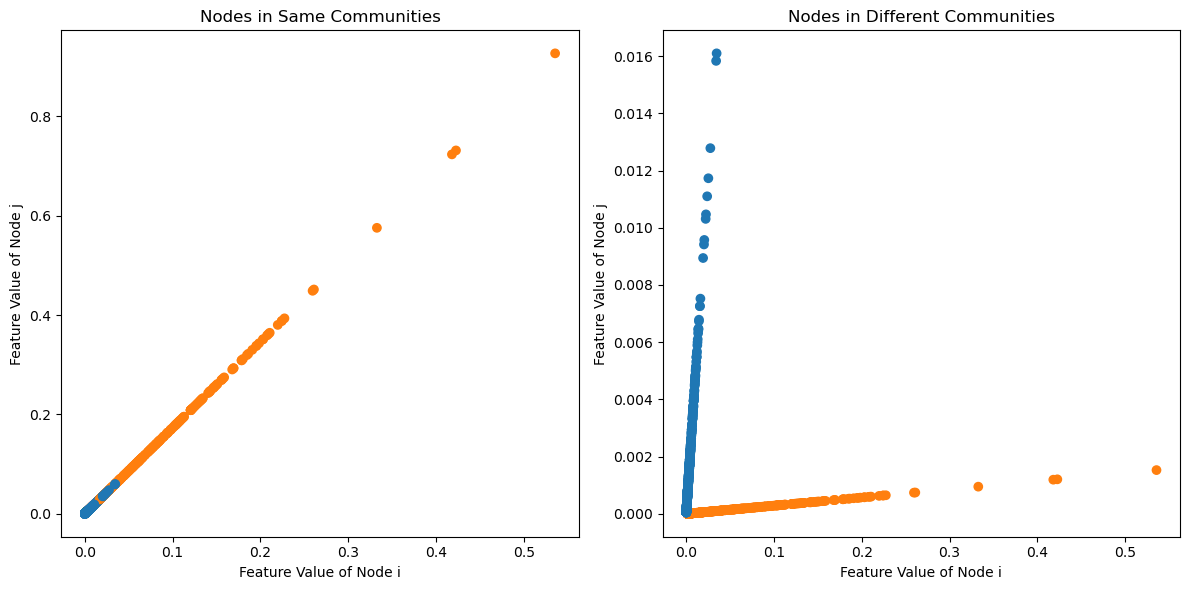

In [25]:
# コミュニティ数2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(A_expected[:, 0], A_expected[:, 1], c=communities, cmap=cmap_2color)
ax1.set_title('Nodes in Same Communities')
ax1.set_xlabel('Feature Value of Node i')
ax1.set_ylabel('Feature Value of Node j')

ax2.scatter(A_expected[:, 0], A_expected[:, -1], c=communities, cmap=cmap_2color)
ax2.set_title('Nodes in Different Communities')
ax2.set_xlabel('Feature Value of Node i')
ax2.set_ylabel('Feature Value of Node j')

plt.tight_layout()
plt.show()

 16%|█▌        | 16/100 [00:38<03:20,  2.39s/it]


平均次数：27


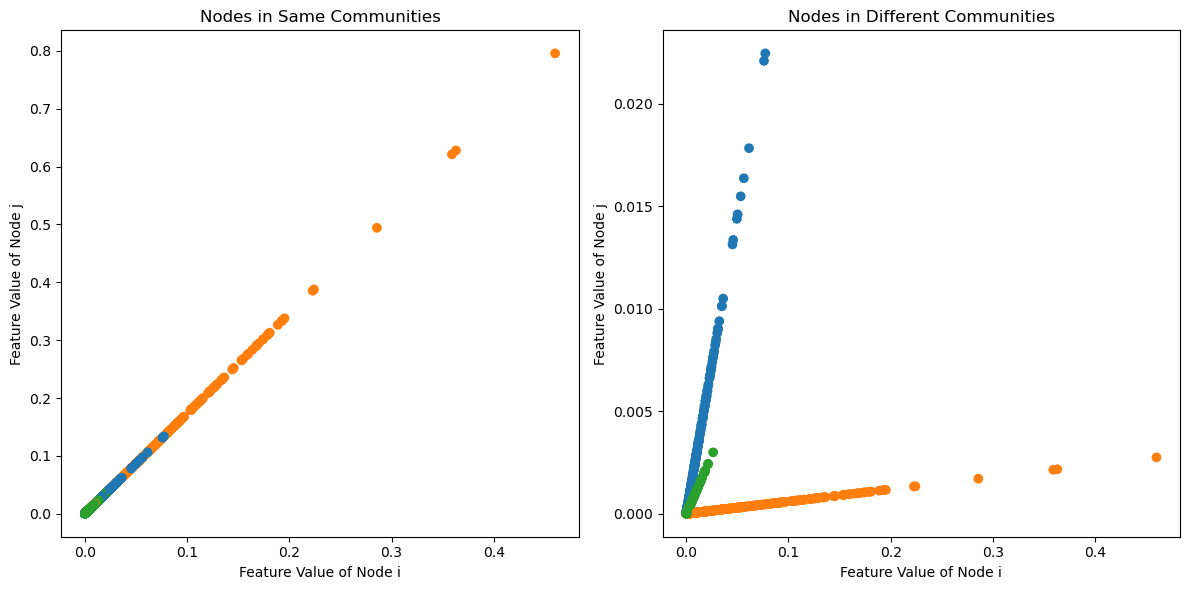

In [26]:
# 最も尤度関数の値の大きい学習結果を採用
max_seed = 16
best_dcsbm = DCSBM_NW.DCSBM(Gs, 3, max_seed, sub_graph=True)
best_dcsbm.fit()
w = best_dcsbm.get_w()
theta = best_dcsbm.get_theta()
communities = best_dcsbm.get_communities()
A_non_weight = best_dcsbm.calculate_adjancency_matrix_sub()
avdg = int(best_dcsbm.get_mean_degree())
A = nx.to_numpy_array(Gs)

N = Gs.number_of_nodes()
A_expected = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        A_expected[i][j] = theta[i]*theta[j]*w[communities[i]][communities[j]]

A_expected_zero = A_expected*A_non_weight

print(f"平均次数：{avdg}")

In [27]:
communities

array([1, 1, 0, ..., 0, 2, 2])

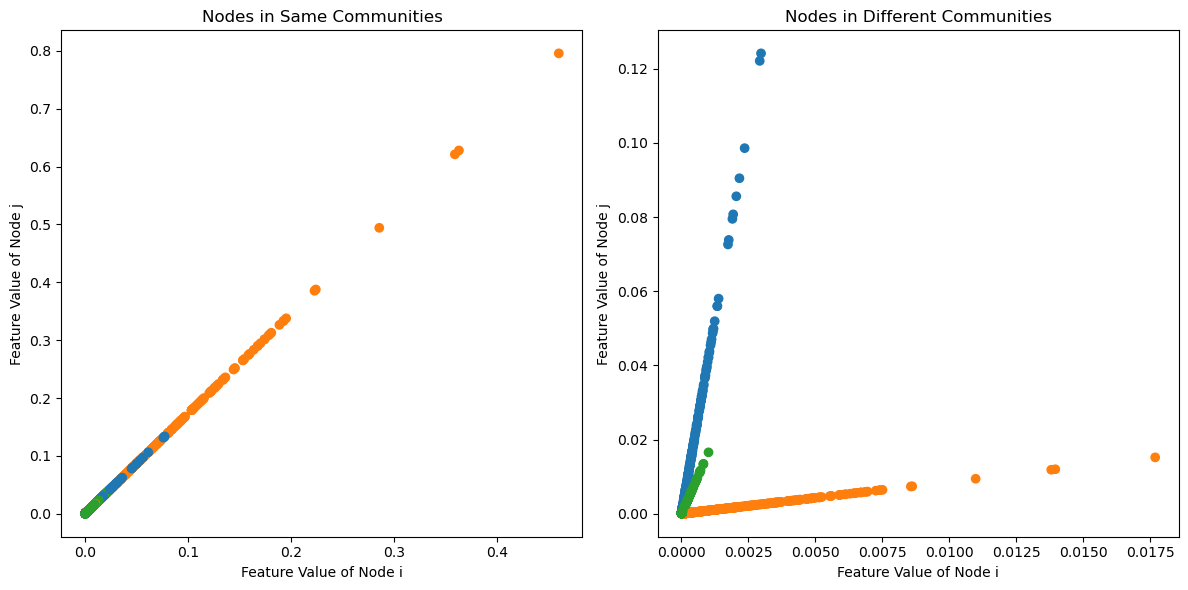

In [29]:
# コミュニティ数3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(A_expected[:, 0], A_expected[:, 1], c=communities, cmap=cmap_3color)
ax1.set_title('Nodes in Same Communities')
ax1.set_xlabel('Feature Value of Node i')
ax1.set_ylabel('Feature Value of Node j')

ax2.scatter(A_expected[:, 3], A_expected[:, -2], c=communities, cmap=cmap_3color)
ax2.set_title('Nodes in Different Communities')
ax2.set_xlabel('Feature Value of Node i')
ax2.set_ylabel('Feature Value of Node j')

plt.tight_layout()
plt.show()

### Polblogs ~ラベルの再現~

In [13]:
# UMAPを適用し、2次元に埋め込む
embedding_orig = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A)
embedding_expected = umap.UMAP(n_components=2, n_neighbors=avdg, random_state=22, metric="cosine").fit_transform(A_expected)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [14]:
# DBSCANクラスタリングの実行
dbscan = DBSCAN(eps=0.5, min_samples=5)  # パラメータは調整が必要
clusters1 = dbscan.fit_predict(embedding_orig)

# クラスタリング結果の表示
unique_clusters = np.unique(clusters1)
n_clusters = len(unique_clusters) - (1 if -1 in clusters1 else 0)  # ノイズポイントを除外
print(f"検出されたクラスタ数: {n_clusters}")

検出されたクラスタ数: 4


In [15]:
# DBSCANクラスタリングの実行
dbscan = DBSCAN(eps=1.0, min_samples=5)  # パラメータは調整が必要
clusters2 = dbscan.fit_predict(embedding_expected)

# クラスタリング結果の表示
unique_clusters = np.unique(clusters2)
n_clusters = len(unique_clusters) - (1 if -1 in clusters2 else 0)  # ノイズポイントを除外
print(f"検出されたクラスタ数: {n_clusters}")

検出されたクラスタ数: 2


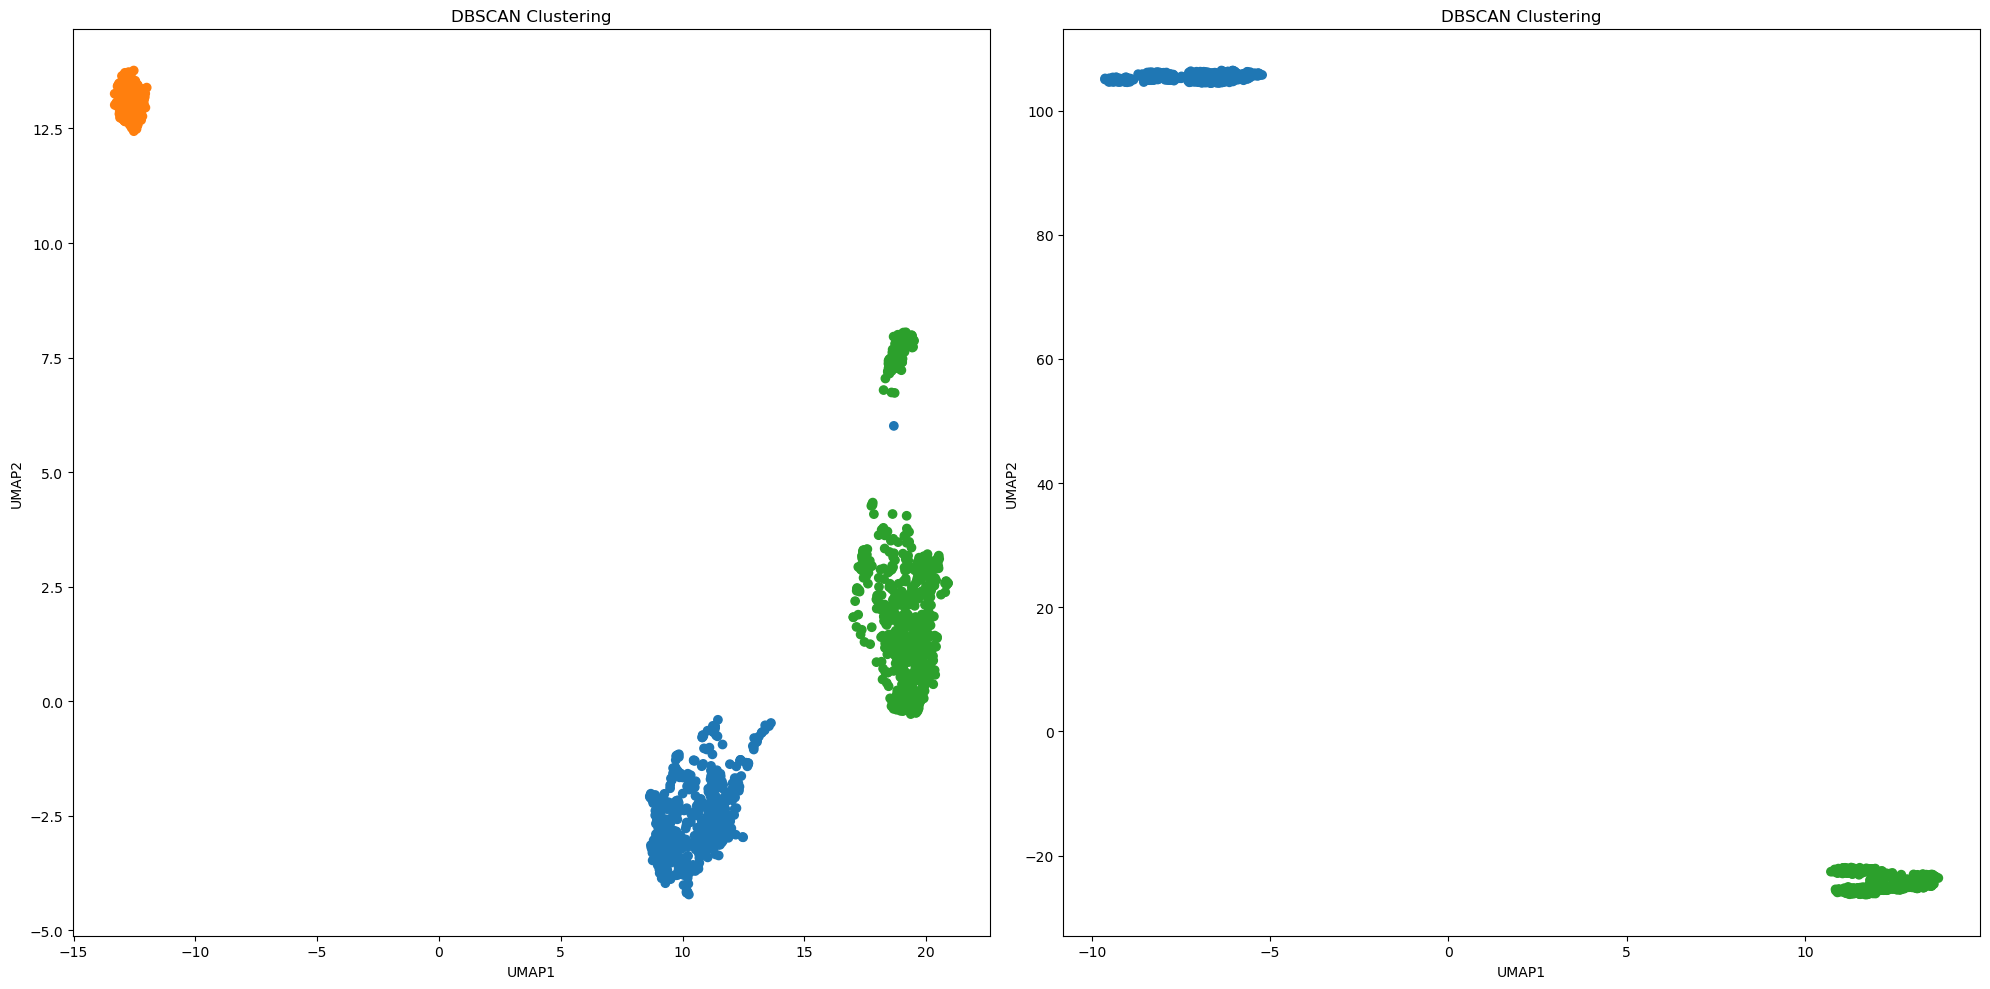

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c=clusters1, cmap=cmap_3color)
ax1.set_title('DBSCAN Clustering')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')

# DBSCANの結果をプロット
ax2.scatter(embedding_expected[:, 0], embedding_expected[:, 1], c=clusters2, cmap=cmap_3color)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')

plt.tight_layout()
plt.show()

In [74]:
print(accuracy_score(communities, clusters1))
print(1-accuracy_score(communities, clusters2))

0.0220949263502455
1.0


In [12]:
A = nx.to_numpy_array(G)


In [17]:
nmi_results = calculate_nmi(true_communities, communities, clusters1, clusters2)

print("NMI Results:")
for comparison, score in nmi_results.items():
    print(f"{comparison}: {score:.4f}")

NMI Results:
true_communities_vs_clusters1: 0.4133
communities_vs_clusters2: 1.0000
